## Name: Prasad Uttam Belote

## 01 - BEGINNER LEVEL TASK

# Task 2 - Music Recommendation System

In [1]:
!pip install missingno
!pip install lightgbm
!pip install catboost

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
import string
import math
import missingno as msno
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import lightgbm as lgbm
import xgboost as xgb
import catboost as cb

## Data Collection

In [3]:
songs_df = pd.read_csv("songs.csv")
songs_extra_df = pd.read_csv("song_extra_info.csv")
members_df = pd.read_csv("members.csv")
train_df = pd.read_csv("train.csv", nrows = 100000)
t_s = pd.merge(train_df, songs_df, on='song_id', how='left')
t_s_se = pd.merge(t_s, songs_extra_df, on='song_id', how='left')
songs = pd.merge(t_s_se, members_df, on='msno', how='left')

In [4]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003,1,0,NaN,7,20120102,20171005


In [5]:
songs.tail()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date
99995,EedNarOVNUU5ppYW/ho+KV8V29zuf7m3+Df5qnQ9FT4=,c7bvJHblBfQGFJG+DcltwclubmlYvIRTT964Lu4WWXI=,my library,Local playlist more,local-playlist,1,236982.0,465,2NE1,NaN,NaN,31.0,I Love You,TWA531200396,14,0,NaN,9,20150321,20170923
99996,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,MZTwICqr12ijCeBaWeKVJZ67Bz7NI0WA4bqB1IwR4jI=,my library,Local playlist more,local-library,0,228241.0,465,One Direction,Wayne Hector| John Ryan| Julian Bunetta| Ed Dr...,Wayne Hector| John Ryan| Julian Bunetta| Ed Dr...,52.0,Steal My Girl,GBHMU1400159,1,0,NaN,7,20120117,20171004
99997,vDi/nHqBu7wb+DtI2Ix4TupWQatUEFR41mDC0c8Voh8=,xK0clTH8TvjG6sKmJXZuMLzhikhlEsolLtx2AHBpmbQ=,my library,Local playlist more,local-library,1,196812.0,465,Michael Giacchino,Mikkel Eriksen|Sia Furler|Tor Erik Hermansen,NaN,52.0,Try Everything,USWD11575402,13,0,NaN,9,20110322,20180403
99998,xyxz9lf8ipoxELeDLlazmHVZHE1ZYqE6iwfJWkH3Ojc=,SoPkcfpiBjDpZSNPN3HdbPI8WAkuenayPXyBRK91T2s=,my library,Local playlist more,local-library,0,215775.0,465,Katy Perry,Katy Perry| Max Martin| Jordan Houston| Lukasz...,NaN,52.0,Dark Horse,USUM71311296,1,0,NaN,7,20120117,20171004
99999,n8TgRhOBw+DthR6N6ie/63yp3KHA20UVHlbK9nY9nIc=,PEEg0ODi9cPg1VXM9EOhZtV39sBJFr/9cIflhbHJ5Bs=,my library,Local playlist more,local-library,1,191425.0,465,孫盛希 (Shi Shi),孫盛希,孫盛希,3.0,你的誰,TWA451499001,1,0,NaN,7,20150706,20170921


In [6]:
songs.shape

(100000, 20)

In [7]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    100000 non-null  object 
 1   song_id                 100000 non-null  object 
 2   source_system_tab       99697 non-null   object 
 3   source_screen_name      95727 non-null   object 
 4   source_type             99805 non-null   object 
 5   target                  100000 non-null  int64  
 6   song_length             99996 non-null   float64
 7   genre_ids               98498 non-null   object 
 8   artist_name             99996 non-null   object 
 9   composer                78528 non-null   object 
 10  lyricist                59309 non-null   object 
 11  language                99996 non-null   float64
 12  name                    99991 non-null   object 
 13  isrc                    91475 non-null   object 
 14  city                 

In [8]:
songs.isnull().sum()

msno                          0
song_id                       0
source_system_tab           303
source_screen_name         4273
source_type                 195
target                        0
song_length                   4
genre_ids                  1502
artist_name                   4
composer                  21472
lyricist                  40691
language                      4
name                          9
isrc                       8525
city                          0
bd                            0
gender                    38672
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64

In [9]:
for i in songs.select_dtypes(include=['object']).columns:
    songs[i][songs[i].isnull()] = 'unknown'
songs = songs.fillna(value=0)

In [10]:
songs.isnull().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
name                      0
isrc                      0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

## Feature Extraction

In [11]:
# registration_init_time
songs.registration_init_time = pd.to_datetime(songs.registration_init_time, format='%Y%m%d', errors='ignore')
songs['registration_init_time_year'] = songs['registration_init_time'].dt.year
songs['registration_init_time_month'] = songs['registration_init_time'].dt.month
songs['registration_init_time_day'] = songs['registration_init_time'].dt.day

# expiration_date
songs.expiration_date = pd.to_datetime(songs.expiration_date,  format='%Y%m%d', errors='ignore')
songs['expiration_date_year'] = songs['expiration_date'].dt.year
songs['expiration_date_month'] = songs['expiration_date'].dt.month
songs['expiration_date_day'] = songs['expiration_date'].dt.day

In [12]:
songs=songs.drop(["registration_init_time_year","expiration_date_year"],axis=1)

In [13]:
songs.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,city,bd,gender,registered_via,registration_init_time,expiration_date,registration_init_time_month,registration_init_time_day,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,unknown,52.0,Good Grief,GBUM71602854,1,0,unknown,7,2012-01-02,2017-10-05,1,2,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,unknown,unknown,52.0,Lords of Cardboard,US3C69910183,13,24,female,9,2011-05-25,2017-09-11,5,25,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,unknown,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,13,24,female,9,2011-05-25,2017-09-11,5,25,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,unknown,-1.0,Disco Africa,GBUQH1000063,13,24,female,9,2011-05-25,2017-09-11,5,25,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,unknown,52.0,Sleep Without You,QM3E21606003,1,0,unknown,7,2012-01-02,2017-10-05,1,2,10,5


In [14]:
label_encoder = LabelEncoder()
one_hot = OneHotEncoder()

for i in songs.columns :
    songs[i] = label_encoder.fit_transform(songs[i])

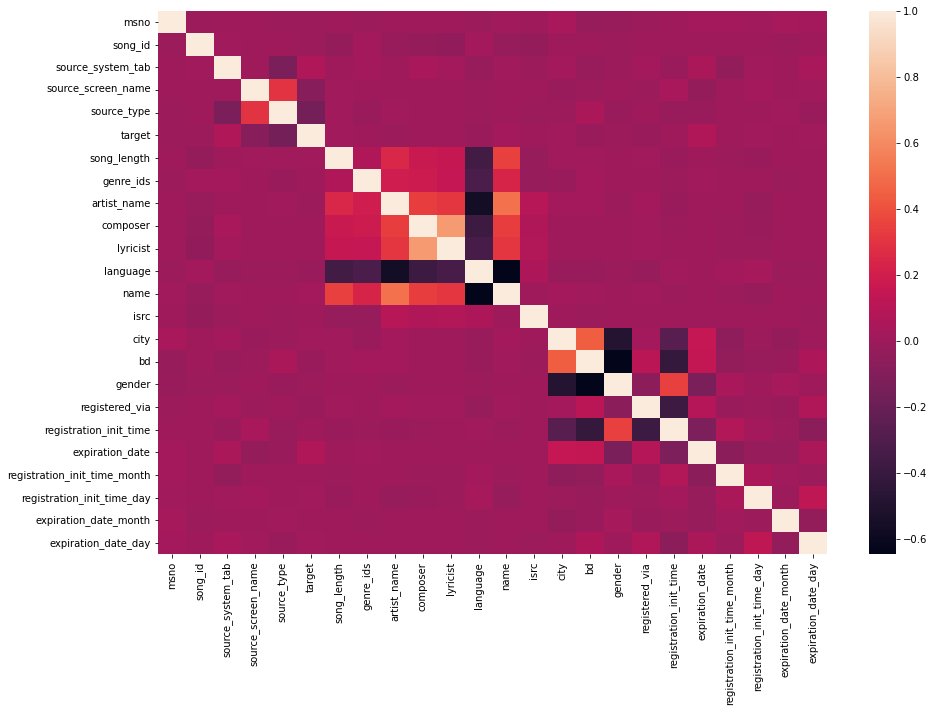

In [15]:
plt.figure(figsize=[15,10])
sns.heatmap(songs.corr())
plt.show()

## Model Building

In [16]:
X = songs.drop('target', axis = 1)
y = songs.target
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [17]:
def model_with(model_name, X_train, X_val, y_train, y_val) :
    print("==================================================")
    print("Modeling with :", model_name)
    print()
        
    if model_name == "Random Forest Classifier" :
        model = RandomForestClassifier(
            n_estimators=1000, 
        )
    elif model_name == "Extra Trees Classifier" :
        model = ExtraTreesClassifier(
            n_estimators=1000, 
        )
    elif model_name == "LightGBM Classifier" :
        model = lgbm.LGBMClassifier(
            n_estimators=1000, 
        )
    elif model_name == "XGBoost Classifier" :
        model = xgb.XGBClassifier(
            n_estimators=1000, 
        )
    elif model_name == "CatBoost Classifier" :
        model = cb.CatBoostClassifier(
            n_estimators=1000, 
            verbose=0
        )
    else :
        print("Model not found in function.")
        
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    print(classification_report(y_val, val_pred))
    print()
    print("Accuracy :", accuracy_score(y_val, val_pred))
    print("ROC :", roc_auc_score(y_val, val_pred))
    
    print("==================================================")
    print()

In [ ]:
models = ["Random Forest Classifier", "Extra Trees Classifier", "LightGBM Classifier", "XGBoost Classifier", "CatBoost Classifier"]
for i in models :
    model_with(i, X_train, X_val, y_train, y_val)

Modeling with : Random Forest Classifier

              precision    recall  f1-score   support

           0       0.77      0.55      0.64      6176
           1       0.86      0.95      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.82      0.75      0.77     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.8468
ROC : 0.7456853875770982

Modeling with : Extra Trees Classifier

              precision    recall  f1-score   support

           0       0.75      0.57      0.65      6176
           1       0.87      0.94      0.90     18824

    accuracy                           0.85     25000
   macro avg       0.81      0.75      0.77     25000
weighted avg       0.84      0.85      0.84     25000


Accuracy : 0.84592
ROC : 0.7534237243162185

Modeling with : LightGBM Classifier



In [ ]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)
val_pred = rf.predict(X_val)
print("Accuracy :", accuracy_score(y_val, val_pred))